In [1]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [2]:
API_key = 'MCO3JQL81ATB1YZ0'
time = TimeSeries(key = API_key,output_format='pandas')

In [3]:
ticker = 'TSLA'
data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')

In [4]:
df = data[0]
df = df.rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})
result = [group[1] for group in df.groupby(df.index.day)]

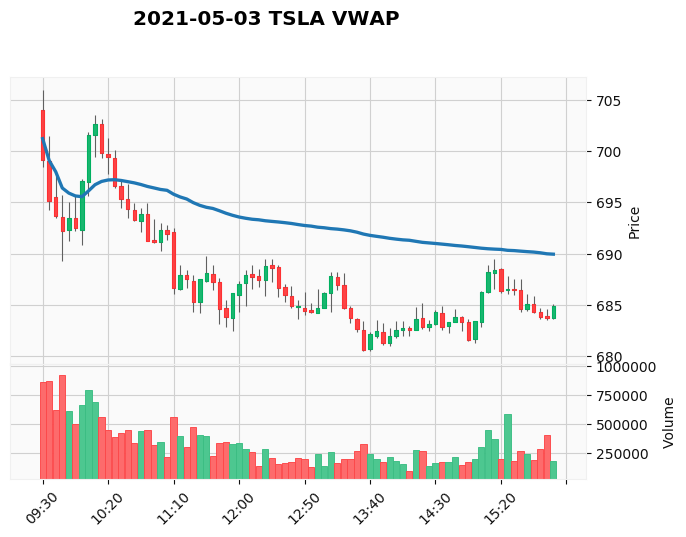

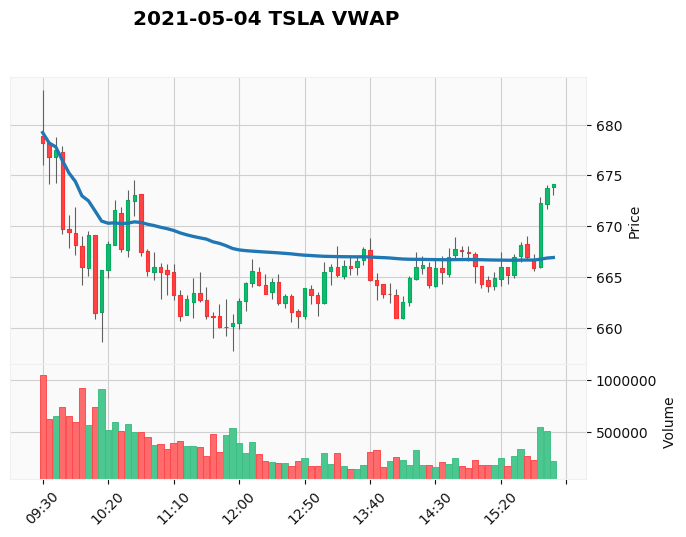

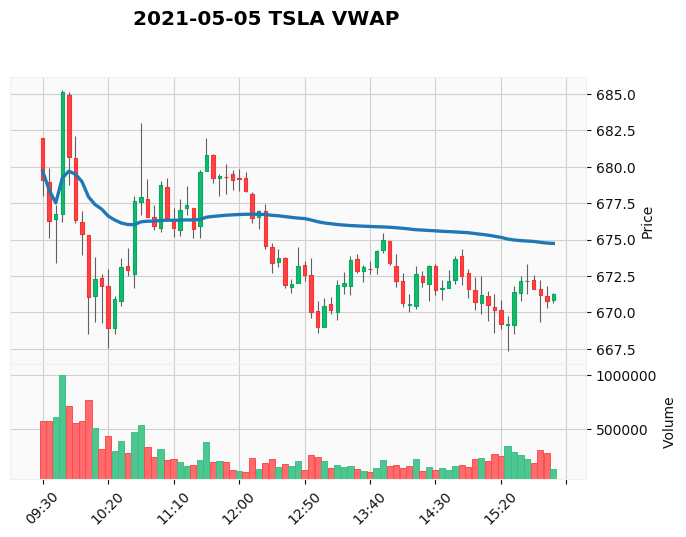

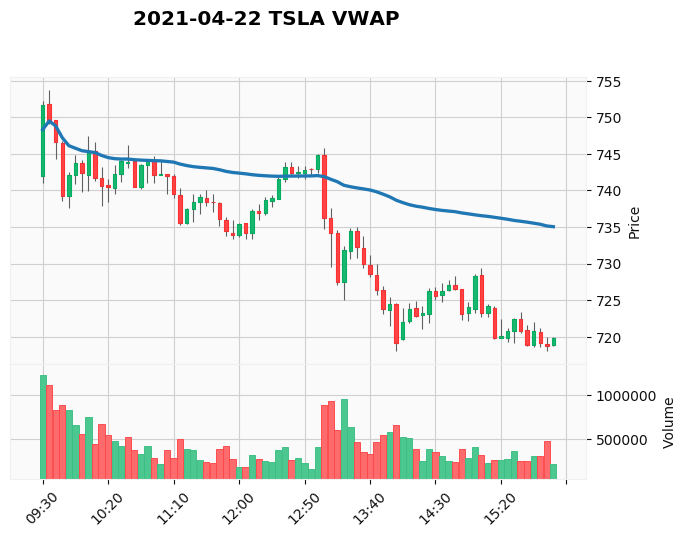

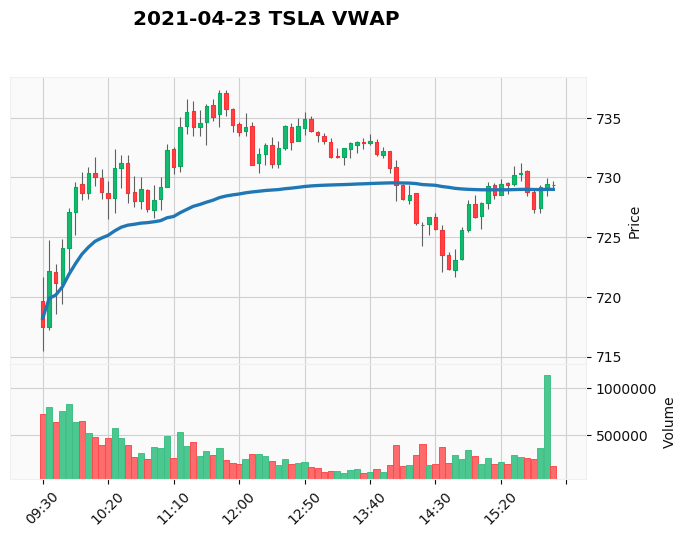

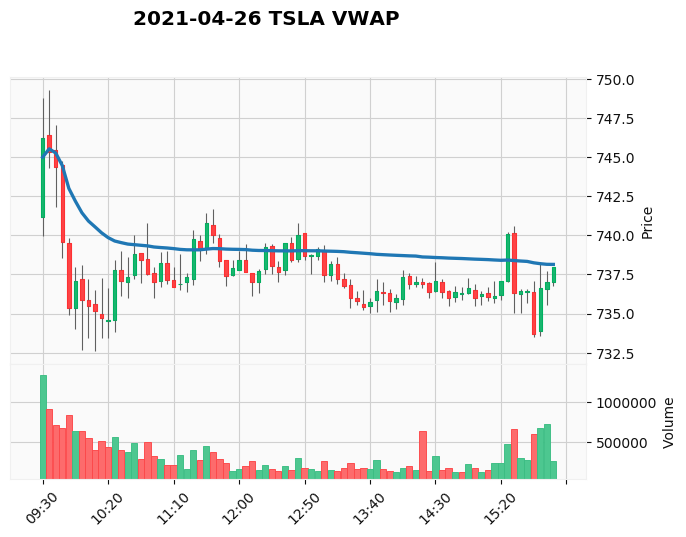

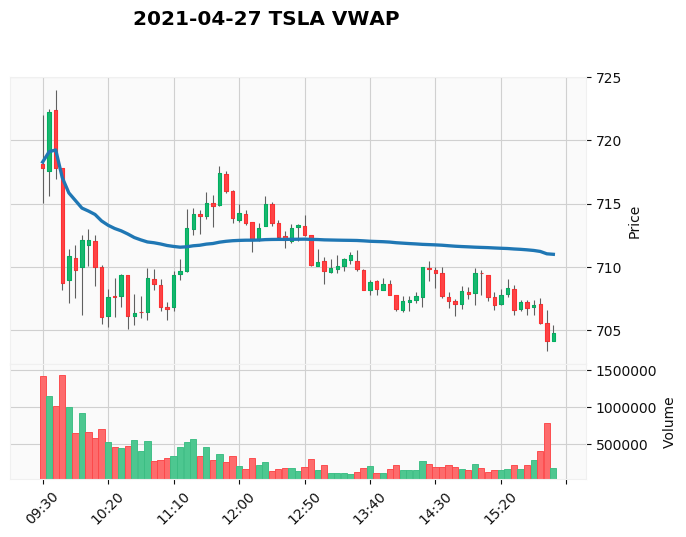

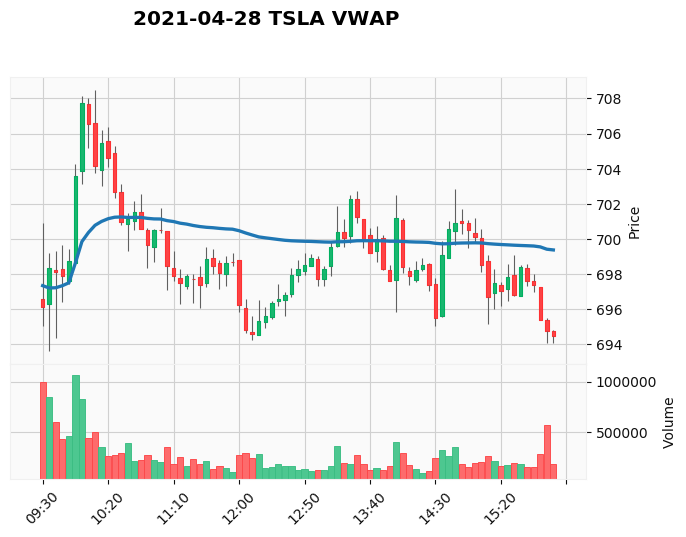

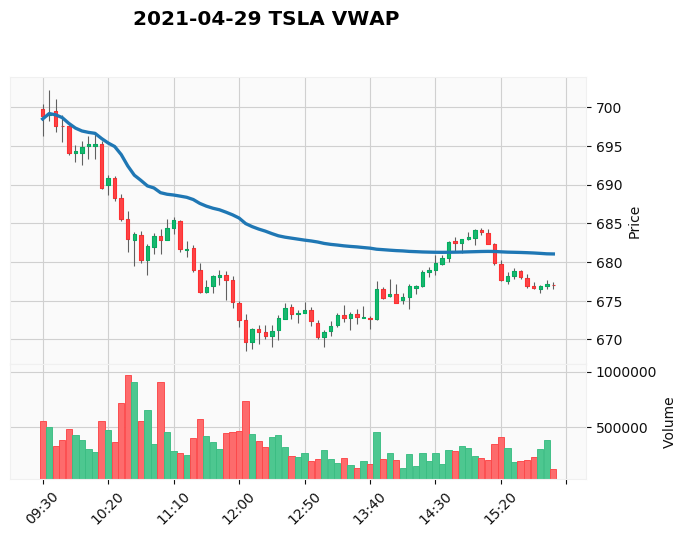

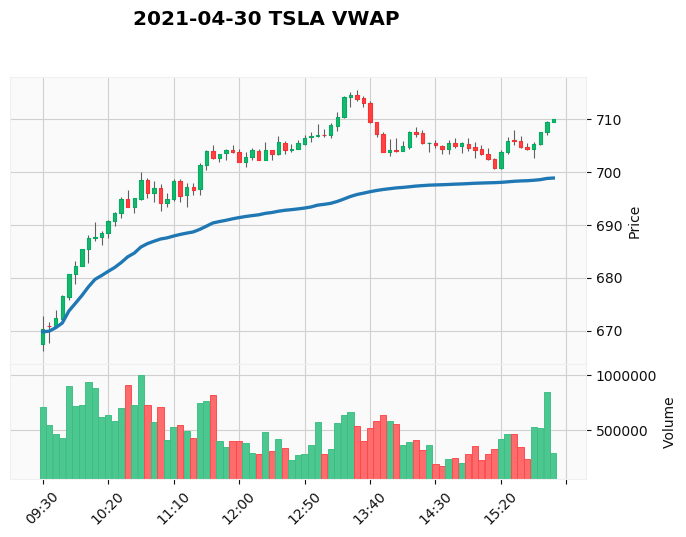

In [14]:
for df_vwap in result:
    df_vwap = df_vwap.loc[(df_vwap.index >= f'{df_vwap.index.date[0]} 9:30:00')]
    df_vwap = df_vwap.loc[(df_vwap.index <= f'{df_vwap.index.date[0]} 16:00:00')]
    df_vwap = df_vwap.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
    df_vwap['VWAP'] = (((df_vwap['High']+df_vwap['Low']+df_vwap['Close'])*df_vwap['Volume']/3).cumsum())/df_vwap['Volume'].cumsum()
    df_vwap = df_vwap.dropna()
    vwap = mpf.make_addplot(df_vwap['VWAP'])
    mpf.plot(df_vwap,addplot=[vwap],type='candle',style='yahoo',volume=True,title=f"{df_vwap.index.date[0]} {ticker} VWAP")

In [6]:
def strategy1(df_vwap,cash):
    shares = 0
    cash0 = cash
    print(f'{df_vwap.index.date[0]}')
    for index,row in df_vwap.iterrows():
        if ((row['VWAP'] < row['Close']) and cash):
            shares = cash/row['Close']
            print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = 0
        if ((row['VWAP'] > row['Close']) and not cash):
            cash = shares*row['Close']
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            shares = 0
        price = row['Close']
    cash = cash + shares*price
    print(f'Cash: {cash}')
    print(f'Return: {((cash - cash0)/cash0)*100:.2f}%')
    return